In [60]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [61]:
def f(x):
    return 3*x**2 -4*x +5

In [62]:
f(3.0)

20.0

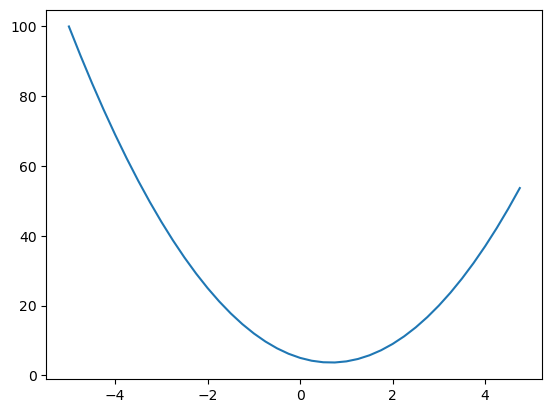

In [63]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)
plt.show()

In [64]:
h = 0.0000001
x = 2/3
f(x)
(f(x+h)-f(x))/h

2.9753977059954195e-07

In [65]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [80]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0 # stores dLoss/dself
        self._backward = lambda: None # node-specific function that determines how to propogate gradient from parent to children
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __radd__(self, other): # called when given other + self
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __rmul__(self, other): # called when given other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**(-1)

    def __neg__(self):
        return self * (-1)

    def __sub__(self, other):
        return self + (other * -1)

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * (self.data**(other-1))) * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        out = Value(np.tanh(self.data), (self,), 'tanh')

        def _backward():
            self.grad += (1 - out.data**2) * out.grad 
        out._backward = _backward
            
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad # out.data == math.exp(x)
        out._backward = _backward

        return out

    def backward(self):
        # calculate d_self/d_ancestors for any node self
        topo_graph = []
        visited = set()

        def topo_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topo_sort(child)
                topo_graph.append(v)
        topo_sort(self)

        self.grad = 1.0
        for node in reversed(topo_graph):
            node._backward()

In [81]:
from graphviz import Digraph

# visualize the logical graph of values (nodes) and their ops (edges)
# --> nice for building intuition for backprop

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={'rankdir': 'LR'}) # LR is left-to-right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value n the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad, ), shape='record')
        if n._op:
            # if this value is the result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect the nodes
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node for n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [82]:
# input vector x = [x1,x2]
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weight vector w = [w1,w2]
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# neuron bias
b = Value(6.8813735870195432, label='b')
# output = x1w1 + x2w2 + b
x1w1 = x1 * w1
x1w1.label = 'x1w1'
x2w2 = x2 * w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b
n.label = 'n'
o = n.tanh()
o.label = 'o'
o.grad = 1.0
o.backward()

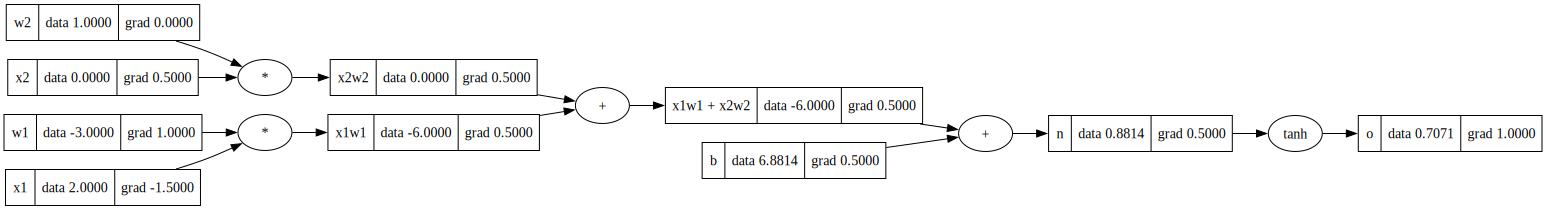

In [83]:
draw_dot(o)

In [84]:
import torch

x1 = torch.Tensor([2.0]).double()
x2 = torch.Tensor([0.0]).double()
w1 = torch.Tensor([-3.0]).double()
w2 = torch.Tensor([1.0]).double()
b = torch.Tensor([6.8813735870195432]).double()

x1.requires_grad = True
x2.requires_grad = True
w1.requires_grad = True
w2.requires_grad = True
b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
----
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [85]:
import random

In [116]:
class Neuron:

    def __init__(self, n_in):
        # initialize (n_in) weights and bias randomly
        self.w = [Value(random.uniform(-1,1)) for _ in range(n_in)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # (w dot x) + b computes neuron activation on input vector x
        activation = sum((w_i * x_i for w_i, x_i in zip(self.w, x)), self.b)
        out = activation.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, n_in, n_out):
        # create FC layer of (n_out) Neuron objects
        self.neurons = [Neuron(n_in) for _ in range(n_out)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
         

class MLP:
    
    def __init__(self, n_in, n_outs):
        # create MLP with (n_in) inputs, (len(n_outs)-1) hidden layers, and 1 output layer, each with size according to n_outs[i]
        size = [n_in] + n_outs
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(n_outs))]

    def __call__(self, x):
            for layer in self.layers:
                x = layer(x)
            return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [169]:
x = [1.0, 2.0, 3.0]
n = MLP(3, [4,4,1]) # MLP with 3 inputs, 2 hidden layers of size 4, and 1 output
n(x) # different every call

Value(data=-0.4048412686776756)

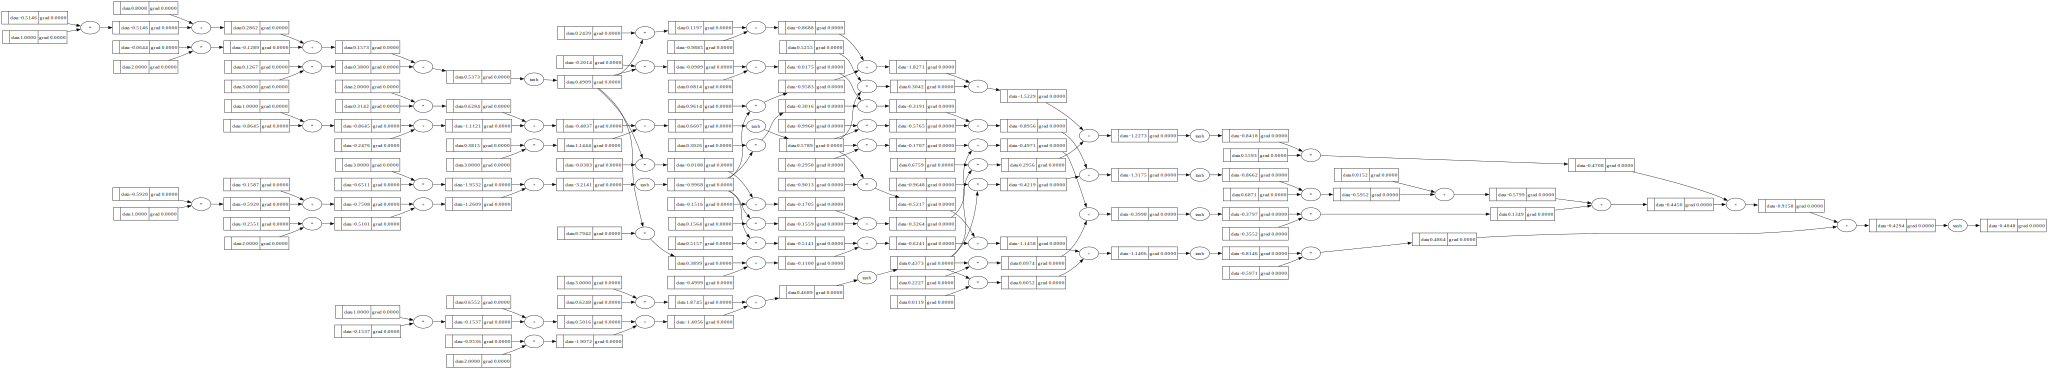

In [170]:
draw_dot(n(x))

In [171]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired outputs
ypred = [n(x) for x in xs]
ypred

# we want to iteratively improve the neural network such that its predictions (ypred) 
# more closely approximate the desired output (ys)
# --> accomplish this by using a loss function L to map our prediction to a scalar that
# --> encodes how good or bad the prediction was

[Value(data=0.45775124809910595),
 Value(data=-0.28407727951584905),
 Value(data=-0.42429418656370965),
 Value(data=0.06454642351329523)]

In [172]:
loss = sum((y_out - y_gt)**2 for y_gt, y_out in zip(ys, ypred))
loss

Value(data=2.013089628029613)

In [180]:
for k in range(20): # 20 chosen arbitrarily for num epochs

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((y_out - y_gt)**2 for y_gt, y_out in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0 # .zero_grad()
    loss.backward()

    # update
    for p in n.parameters():
        p.data += 0.05 * -p.grad

    print(k, loss.data)


0 0.0004794264679508937
1 0.00047896376651704895
2 0.0004785019343401533
3 0.00047804096900126215
4 0.00047758086809034344
5 0.00047712162920621973
6 0.0004766632499565509
7 0.0004762057279577733
8 0.00047574906083506634
9 0.0004752932462223164
10 0.00047483828176207195
11 0.0004743841651055038
12 0.00047393089391238163
13 0.00047347846585100474
14 0.0004730268785981878
15 0.00047257612983921696
16 0.0004721262172678075
17 0.00047167713858606145
18 0.0004712288915044473
19 0.0004707814737417418


In [181]:
ypred

[Value(data=0.992211033413694),
 Value(data=-0.9923271759805972),
 Value(data=-0.9877705323700601),
 Value(data=0.9857985435143195)]